In [1]:
!pip install SPARQLWrapper


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.0/569.0 kB 7.8 MB/s eta 0:00:00


Starting DBPedia Famous Persons Network Project...

--- Query 1: People Born in Same City as Einstein ---
Person Name                    | Birthplace     
-----------------------------------------------
Ernst Albrecht (footballer)    | German Empire  
Ludwig Goldbrunner             | German Empire  
Rudolf Schlichter              | German Empire  
Rudolf Schlichter              | Kingdom of Württemberg
Siegfried Fehmer               | German Empire  
Walter Brack                   | German Empire  
Arthur Böckenhauer             | German Empire  
Arthur Golf                    | German Empire  
Arthur Hess (SA general)       | German Empire  
Arthur Lieberasch              | German Empire  
Arthur Pieck                   | German Empire  
Arthur Sodtke                  | German Empire  
Erich Przywara                 | German Empire  
Heinrich Albertz               | German Empire  
Konrad Frey                    | German Empire  



--- Query 2: Building Famous Persons Co-Birthplace N

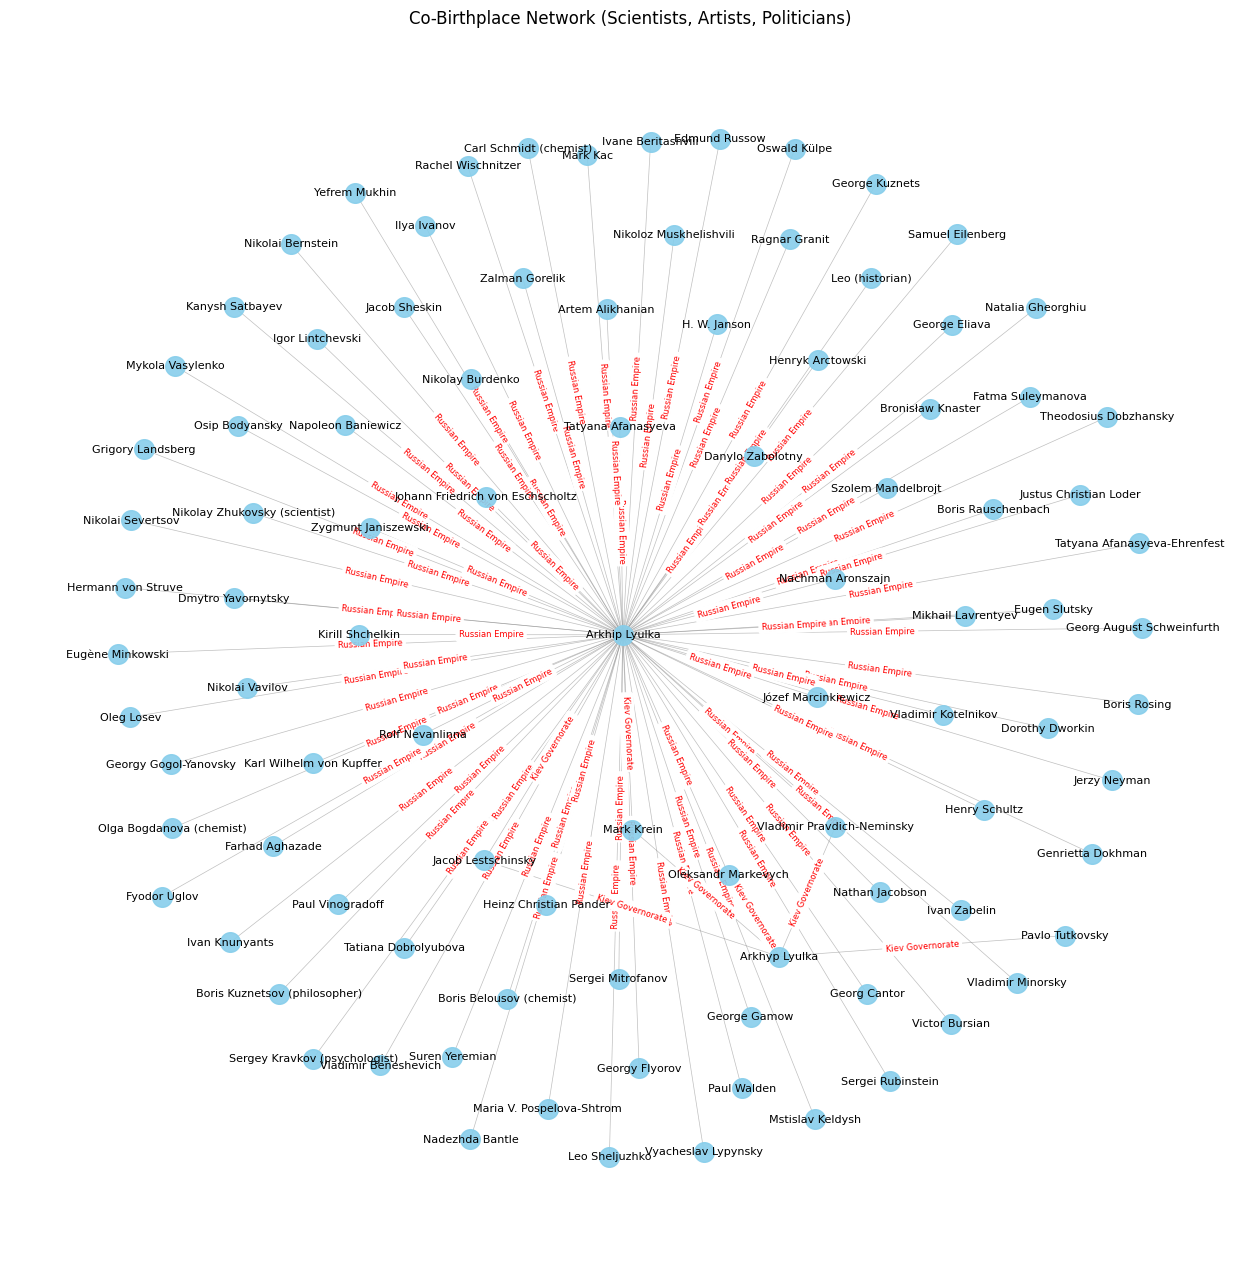


Project finished.


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

def run_query(query, description):
    """
    Helper function to run a SPARQL query against the DBPedia endpoint
    and return the JSON results.
    """
    # Set the DBPedia SPARQL endpoint
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    print(f"\n--- {description} ---")
    try:
        # Run the query and convert the result
        results = sparql.query().convert()
        return results["results"]["bindings"]
    except Exception as e:
        print(f"Error querying DBPedia: {e}")
        print("This might be a network issue or a DBPedia endpoint timeout.")
        return []

def run_einstein_query():
    """
    Runs the specific query for "Who was born in the same city as Einstein?"
    and prints the results to the console.
    """
    einstein_query = """
    PREFIX dbr: <http://dbpedia.org/resource/>
    PREFIX dbo: <http://dbpedia.org/ontology/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?personName ?birthPlaceName
    WHERE {
      # 1. Find Einstein's birthplace (Ulm)
      dbr:Albert_Einstein dbo:birthPlace ?birthPlace .

      # 2. Find other people with that same birthplace
      ?person dbo:birthPlace ?birthPlace .

      # 3. Get the human-readable names (labels)
      ?person rdfs:label ?personName .
      ?birthPlace rdfs:label ?birthPlaceName .

      # 4. Filter out Einstein himself
      FILTER (?person != dbr:Albert_Einstein)

      # 5. Filter for English language labels only
      FILTER (lang(?personName) = "en")
      FILTER (lang(?birthPlaceName) = "en")
    }
    LIMIT 15
    """

    einstein_results = run_query(einstein_query, "Query 1: People Born in Same City as Einstein")

    if einstein_results:
        print(f"{'Person Name':<30} | {'Birthplace':<15}")
        print("-" * 47)
        for res in einstein_results:
            person_name = res["personName"]["value"]
            birthplace = res["birthPlaceName"]["value"]
            print(f"{person_name:<30} | {birthplace:<15}")
    else:
        print("No results found for Einstein query.")

def build_and_visualize_network():
    """
    Runs the main network query for scientists, artists, and politicians,
    builds a graph with NetworkX, and displays it with Matplotlib.
    """

    # This query finds pairs of people (person1, person2) who
    # share a birthplace and are of the specified types.
    network_query = """
    PREFIX dbo: <http://dbpedia.org/ontology/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?person1Name ?person2Name ?birthPlaceName
    WHERE {
      # 1. Define the types (classes) we are interested in
      VALUES ?type { dbo:Scientist dbo:Artist dbo:Politician }

      # 2. Find person 1 of that type and their birthplace
      ?person1 a ?type ;
               dbo:birthPlace ?birthPlace ;
               rdfs:label ?person1Name .

      # 3. Find person 2 of the same type and birthplace
      ?person2 a ?type ;
               dbo:birthPlace ?birthPlace ;
               rdfs:label ?person2Name .

      # 4. Get the birthplace name
      ?birthPlace rdfs:label ?birthPlaceName .

      # 5. Filter for English labels
      FILTER (lang(?person1Name) = "en")
      FILTER (lang(?person2Name) = "en")
      FILTER (lang(?birthPlaceName) = "en")

      # 6. Ensure they are not the same person AND
      #    use STR() comparison to avoid duplicate pairs (A,B) and (B,A)
      FILTER (STR(?person1) < STR(?person2))
    }
    LIMIT 100
    # NOTE: LIMIT is 100 to prevent DBPedia from timing out.
    # For a larger graph, this query would need to be run in batches.
    """

    network_results = run_query(network_query, "Query 2: Building Famous Persons Co-Birthplace Network (Pairs)")

    if not network_results:
        print("No results found for network query. Cannot build graph.")
        return

    print(f"\nFound {len(network_results)} pairs for the graph. Building graph...")

    # Create a new graph
    G = nx.Graph()

    # Process results and build the graph
    for res in network_results:
        p1 = res["person1Name"]["value"]
        p2 = res["person2Name"]["value"]
        place = res["birthPlaceName"]["value"]

        # Add nodes (NetworkX handles duplicates automatically)
        G.add_node(p1)
        G.add_node(p2)

        # Add the edge with the birthplace as an attribute
        G.add_edge(p1, p2, birthplace=place)

    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # --- Visualize the Graph ---
    print("Displaying graph... (This will appear below the cell)")

    plt.figure(figsize=(16, 16))

    # Use a spring layout to spat_layout to spread nodes out
    # 'k' controls the distance between nodes
    try:
        pos = nx.spring_layout(G, k=0.7, iterations=50)
    except nx.NetworkXError as e:
        print(f"Error generating layout (graph might be empty): {e}")
        return

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue', alpha=0.9)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

    # Draw edge labels (the birthplaces)
    edge_labels = nx.get_edge_attributes(G, 'birthplace')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, font_color='red')

    plt.title("Co-Birthplace Network (Scientists, Artists, Politicians)")
    plt.axis('off') # Hide the axes
    plt.show() # This command will render the plot directly in the notebook


# --- Main execution ---
if __name__ == "__main__":
    print("Starting DBPedia Famous Persons Network Project...")

    # Part 1: Run the specific Einstein query
    run_einstein_query()

    print("\n" + "="*50 + "\n")

    # Part 2: Build and visualize the main network
    build_and_visualize_network()

    print("\nProject finished.")